In [1]:
%cd -q '../'

In [2]:
import pickle
from importlib import reload

import helpers as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import f_regression

from src.config import *

# reload(src.config);
# reload(hp);
%matplotlib inline

## Loading intermediary files from artifacts

In [3]:
stage_name = "1_UnivariateAnalysis"

with open(
    file=f"notebooks/artifacts/{stage_name}_features_info.pkl", mode="rb"
) as f_write:
    features_info = pickle.load(f_write)

with open(
    file=f"notebooks/artifacts/{stage_name}_df_train.pkl", mode="rb"
) as f_write:
    df_train = pickle.load(f_write)

with open(
    file=f"notebooks/artifacts/{stage_name}_df_test.pkl", mode="rb"
) as f_write:
    df_test = pickle.load(f_write)

del stage_name

<h1>Bivariate Analysis

## Handling missing values

In [4]:
df_train["Alley"] = df_train["Alley"].cat.add_categories("NA_str").fillna("NA_str")
df_test["Alley"] = df_test["Alley"].cat.add_categories("NA_str").fillna("NA_str")
df_train["MasVnrType"] = df_train["MasVnrType"].cat.add_categories("NA_str").fillna("NA_str")
df_test["MasVnrType"] = df_test["MasVnrType"].cat.add_categories("NA_str").fillna("NA_str")
df_train["GarageType"] = df_train["GarageType"].cat.add_categories("NA_str").fillna("NA_str")
df_test["GarageType"] = df_test["GarageType"].cat.add_categories("NA_str").fillna("NA_str")
df_train["MiscFeature"] = df_train["MiscFeature"].cat.add_categories("NA_str").fillna("NA_str")
df_test["MiscFeature"] = df_test["MiscFeature"].cat.add_categories("NA_str").fillna("NA_str")

In [5]:
df_train["LotFrontage"].fillna(df_train["LotFrontage"].median(), inplace=True)
df_test["LotFrontage"].fillna(df_test["LotFrontage"].median(), inplace=True)
df_train["MasVnrM2"].fillna(df_train["MasVnrM2"].median(), inplace=True)
df_test["MasVnrM2"].fillna(df_test["MasVnrM2"].median(), inplace=True)
df_train["GarageYrBlt"].fillna(0, inplace=True)
df_test["GarageYrBlt"].fillna(0, inplace=True)

In [6]:
df_train_na_by_column = df_train.isna().sum()
df_test_na_by_column = df_test.isna().sum()

df_train_na_columns = df_train_na_by_column[df_train_na_by_column > 0].index.values
df_test_na_columns = df_test_na_by_column[df_test_na_by_column > 0].index.values

for c in df_train_na_columns:
    if c in features_info["numerical"]:
        df_train[c].fillna(df_train[c].median(), inplace=True)
    elif c in features_info["ordinal"] + features_info["nominal"] + features_info["binary"]:
        df_train[c].fillna(df_train[c].mode().values[0], inplace=True)

for c in df_test_na_columns:
    if c in features_info["numerical"]:
        df_test[c].fillna(df_test[c].median(), inplace=True)
    elif c in features_info["ordinal"] + features_info["nominal"] + features_info["binary"]:
        df_test[c].fillna(df_test[c].mode().values[0], inplace=True)

## Plotting interesting column relations

### 'FullBaths' by 'HalfBaths'

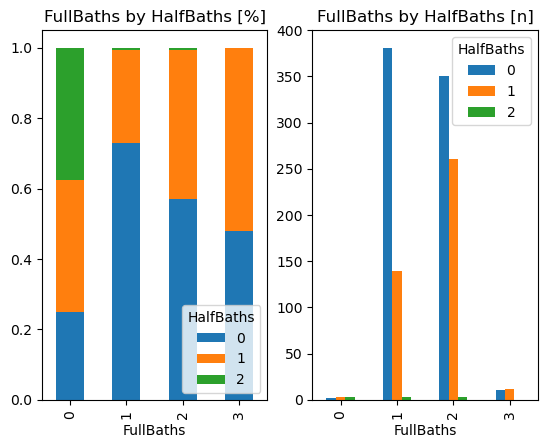

In [7]:
_, ax = plt.subplots(1, 2)

(
    (df_train
    .groupby(['FullBaths', 'HalfBaths'], observed=True)
    .size() / df_train.groupby(['FullBaths'], observed=True).size())
    .unstack()
    .plot.bar(
        title="FullBaths by HalfBaths [%]", ax=ax[0], stacked=True
    )
)

(
    df_train
    .groupby(['FullBaths', 'HalfBaths'], observed=True)
    .size()
    .unstack()
    .plot.bar(
        title="FullBaths by HalfBaths [n]", ax=ax[1]
    )
);

Houses that have 2 full bathrooms are more likely to have more half bathrooms.

### 'TotalRooms' by 'FullBaths'

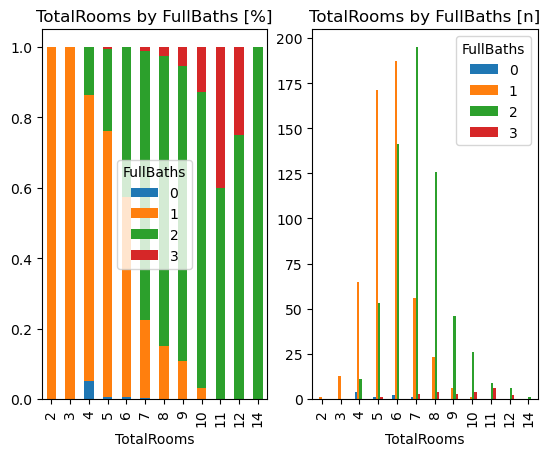

In [8]:
_, ax = plt.subplots(1, 2)

(
    (df_train
    .groupby(['TotalRooms', 'FullBaths'], observed=True)
    .size() / df_train.groupby(['TotalRooms'], observed=True).size())
    .unstack()
    .plot.bar(
        title="TotalRooms by FullBaths [%]", ax=ax[0], stacked=True
    )
)

(
    df_train
    .groupby(['TotalRooms', 'FullBaths'], observed=True)
    .size()
    .unstack()
    .plot.bar(
        title="TotalRooms by FullBaths [n]", ax=ax[1]
    )
);

There is a fairly good sample size of houses with total rooms: 5, 6, 7 and 8.
Analyzing them, one can notice there is a high rise of houses with 2 full bathrooms between houses with total rooms 6 and 7.

<Axes: title={'center': 'HeatingQ by CentralAir [n]'}, xlabel='HeatingQ'>

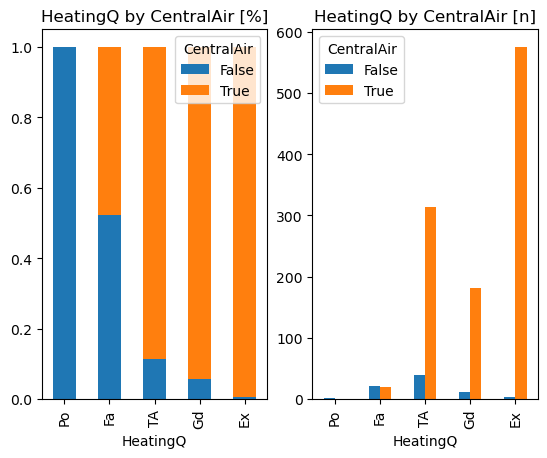

In [9]:
_, ax = plt.subplots(1, 2)

(
    (
        df_train
        .groupby(["HeatingQ", "CentralAir"], observed=True)
        .size()
        / 
        df_train
        .groupby(["HeatingQ"], observed=True)
        .size()
    )
    .unstack()
    .plot.bar(title="HeatingQ by CentralAir [%]", ax=ax[0], stacked=True)
)

(
    df_train
    .groupby(["HeatingQ", "CentralAir"], observed=True)
    .size()
    .unstack()
    .plot.bar(title="HeatingQ by CentralAir [n]", ax=ax[1])
)

As heating quality increases, so does increase number of houses with centrail air.

## Correlation of features

In [10]:
display(hp.get_correlations_and_pvals(df_train, features_info["numerical"]).head(50))

,,r,pvalues
GarageM2,GarageCars,0.875746,0.000000e+00
GrLivM2,TotalRooms,0.825901,1.892782e-292
1stFlrM2,TotalBsmtM2,0.807238,2.938937e-269
2ndFlrM2,GrLivM2,0.686462,1.569353e-163
Bedrooms,TotalRooms,0.663367,5.182815e-149
BsmtFullBaths,BsmtFin1M2,0.653623,2.872241e-143
GrLivM2,FullBaths,0.624993,1.456274e-127
2ndFlrM2,TotalRooms,0.620358,3.578092e-125
HalfBaths,2ndFlrM2,0.610631,2.762038e-120
YearBuilt,YearRemodAdd,0.600571,2.093967e-115


## Correlation with label

In [11]:
display(df_train[features_info['numerical']].corrwith(df_train[LABEL]).sort_values(ascending=False, key=lambda x: np.abs(x)))
display(df_train[features_info['binary']].corrwith(df_train[LABEL]).sort_values(ascending=False, key=lambda x: np.abs(x)))

OverallQ           0.791240
GrLivM2            0.714403
GarageCars         0.638467
GarageM2           0.620374
TotalBsmtM2        0.616094
1stFlrM2           0.612449
FullBaths          0.542593
TotalRooms         0.531574
YearBuilt          0.522553
YearRemodAdd       0.511533
Fireplaces         0.482238
MasVnrM2           0.442510
BsmtFin1M2         0.423265
WoodDeckM2         0.332053
OpenPorchM2        0.323528
2ndFlrM2           0.316429
LotFrontage        0.308072
HalfBaths          0.291240
GarageYrBlt        0.264923
LotM2              0.254397
BsmtFullBaths      0.241709
BsmtUnfM2          0.172764
Bedrooms           0.152184
EnclosedPorchM2   -0.151515
Kitchens          -0.136485
PoolM2             0.115189
ScreenPorchM2      0.103036
OverallCond       -0.062709
3SsnPorchM2        0.050096
YrSold            -0.035182
LowQualFinM2      -0.031421
MiscVal           -0.028651
BsmtHalfBaths     -0.004980
BsmtFin2M2         0.000100
dtype: float64

CentralAir    0.255632
dtype: float64

Strange thing is there's negative correlation with label for these features:
'EnclosedPorchM2', 'Kitchens', 'YrSold', 'BsmtHalfBaths', 'MiscVal'. While it's understandable that houses bought earlier might cost less due to inflation, the reasons behind the negative correlations for these other features with label are not immediately obvious and may seem unreasonable.

### Negative correlation with 'EnclosedPorchM2'

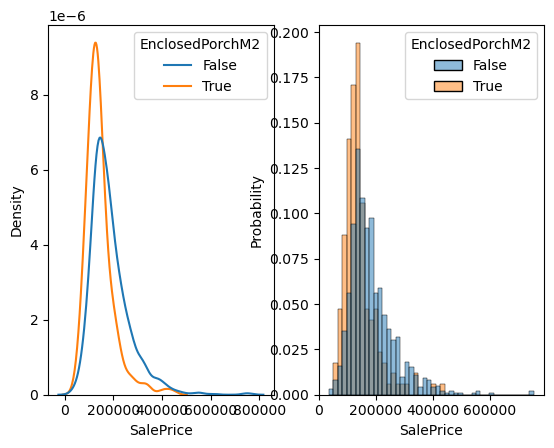

In [12]:
_EnclosedPorchM2_binary = df_train['EnclosedPorchM2'].apply(lambda x: True if x > 0 else False)

fig, ax = plt.subplots(1, 2)

sns.kdeplot(x=df_train[LABEL].astype('float'), hue=_EnclosedPorchM2_binary, common_norm=False, ax=ax[0])
sns.histplot(x=df_train[LABEL].astype('float'), stat='probability', hue=_EnclosedPorchM2_binary, common_norm=False, ax=ax[1])

del _EnclosedPorchM2_binary

Perhaps it would be wise to delete this column.

### Negative correlation with 'Kitchens'

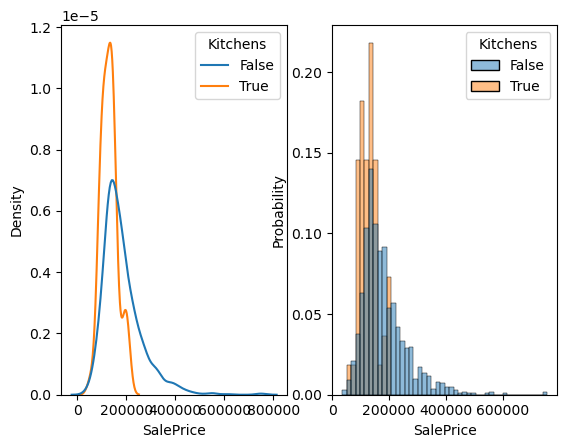

In [13]:
_Kitchens_binary = df_train['Kitchens'].apply(lambda x: True if x > 1 else False)

fig, ax = plt.subplots(1, 2)

sns.kdeplot(x=df_train[LABEL].astype('float'), hue=_Kitchens_binary, common_norm=False, ax=ax[0])
sns.histplot(x=df_train[LABEL].astype('float'), stat='probability', hue=_Kitchens_binary, common_norm=False, ax=ax[1])

del _Kitchens_binary

Perhaps it would be wise to delete this column.

### Negative correlation with 'YrSold'

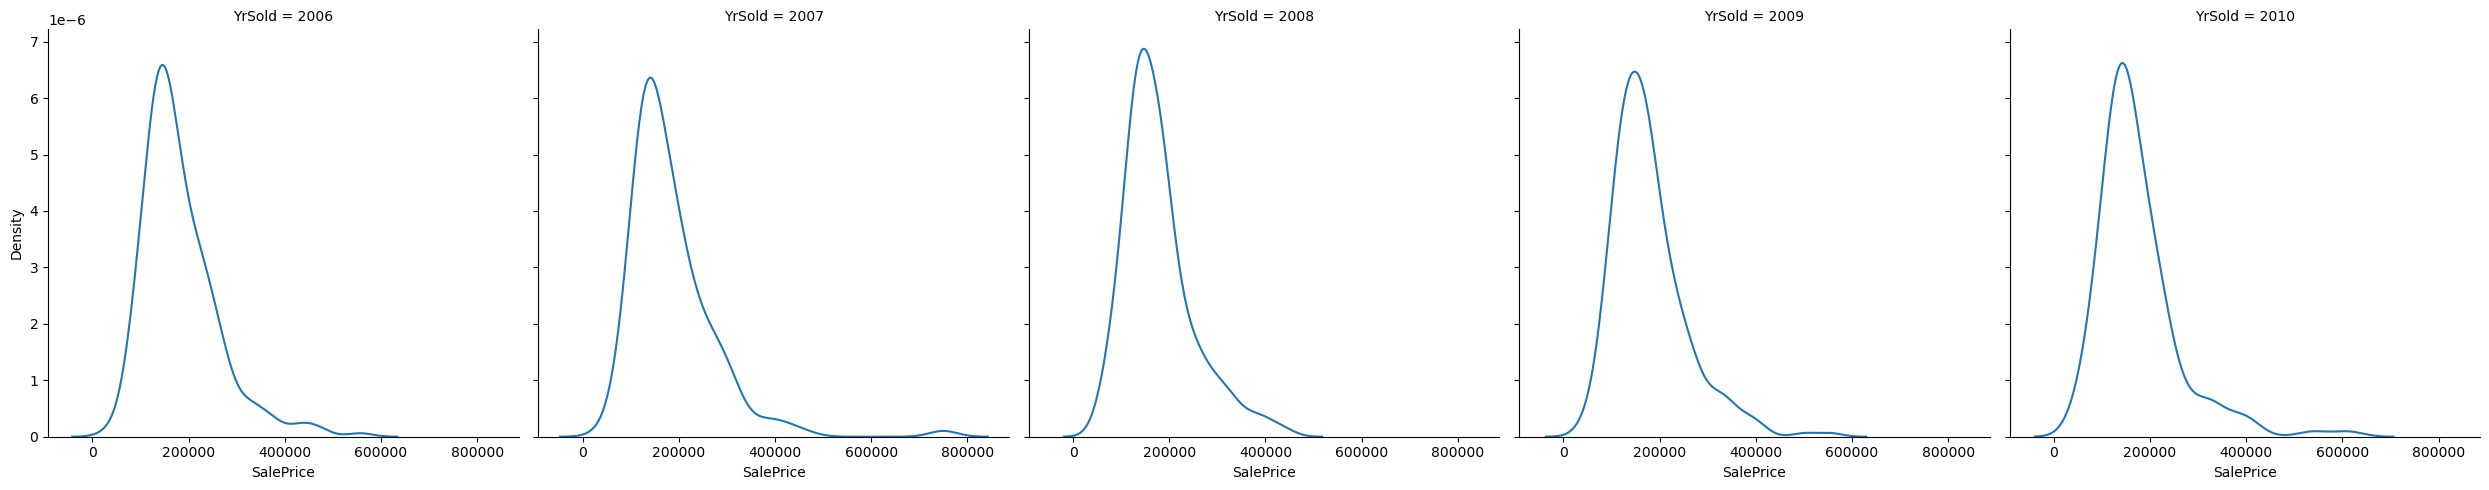

In [14]:
sns.displot(x=df_train[LABEL].astype('float'), kind='kde', col=df_train['YrSold'].astype('int'), common_norm=False);

### Negative correlation with 'BsmtHalfBaths'

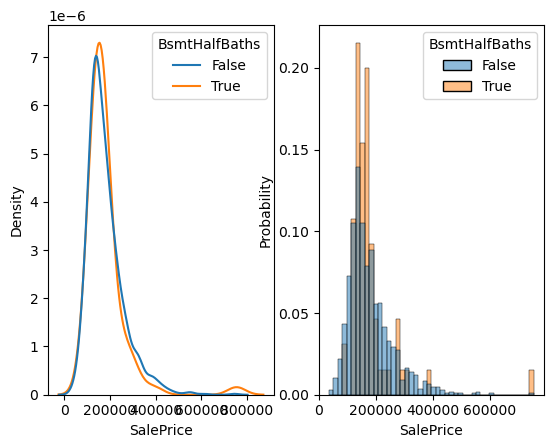

In [15]:
_BsmtHalfBaths_binary = df_train['BsmtHalfBaths'].apply(lambda x: True if x > 0 else False)

fig, ax = plt.subplots(1, 2)

sns.kdeplot(x=df_train[LABEL].astype('float'), hue=_BsmtHalfBaths_binary, common_norm=False, ax=ax[0])
sns.histplot(x=df_train[LABEL].astype('float'), stat='probability', hue=_BsmtHalfBaths_binary, common_norm=False, ax=ax[1]);

Graphs of the two groups almost match.

### Negative correlation with 'MiscVal'

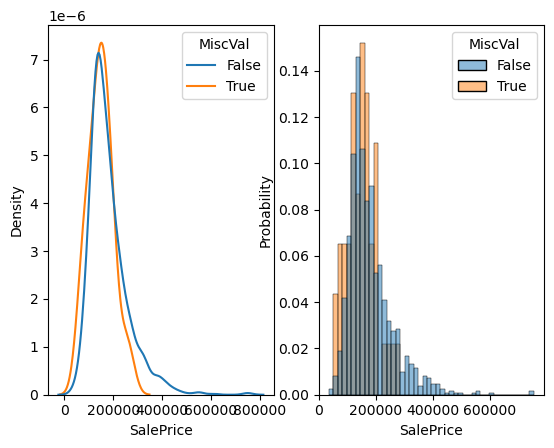

In [16]:
fig, ax = plt.subplots(1, 2)
_MiscVal_binary = df_train['MiscVal'].apply(lambda x: True if x > 0 else False)

sns.kdeplot(x=df_train[LABEL].astype('float'), hue=_MiscVal_binary, common_norm=False, ax=ax[0])
sns.histplot(x=df_train[LABEL].astype('float'), stat='probability', hue=_MiscVal_binary, common_norm=False, ax=ax[1]);

## 'GarageQ' vs 'GarageCond'

In [17]:
_GarageQ_GarageCond_subset = pd.concat([df_train['GarageQ'].cat.codes, df_train['GarageCond'].cat.codes], axis=1) 

f_statistics, p_values = f_regression(_GarageQ_GarageCond_subset, df_train[LABEL])

df_results = pd.DataFrame(
    data={"F statistics": f_statistics, "p values": p_values},
    index=['GarageQ', 'GarageCond'], 
)

display(df_results)

del _GarageQ_GarageCond_subset, f_statistics, p_values, df_results

,F statistics,p values
GarageQ,99.424912,1.577819e-22
GarageCond,89.811025,1.409249e-20


'GarageQ' has a higher value of F statistic, as well as lower p value, so 'GarageCond' will be removed.

In [18]:
features_info['features_to_delete'].append('GarageCond')

### Make sure LABEL column is last

In [19]:
y_train = df_train[LABEL]
y_test = df_test[LABEL]
df_train.drop(LABEL, axis=1, inplace=True)
df_test.drop(LABEL, axis=1, inplace=True)
df_train = pd.concat([df_train, y_train], axis=1)
df_test = pd.concat([df_test, y_test], axis=1)

### Saving intermediary files in artifacts directory

In [20]:
stage_name = "2_MultivariateAnalysis"

with open(
    file=f"notebooks/artifacts/{stage_name}_features_info.pkl", mode="wb"
) as file:
    pickle.dump(features_info, file)

df_train.to_pickle(path=f"notebooks/artifacts/{stage_name}_df_train.pkl")
df_test.to_pickle(path=f"notebooks/artifacts/{stage_name}_df_test.pkl")

del stage_name